In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.interpolate import UnivariateSpline

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True

In [4]:
def my_obj(preds, train_data):
    labels = train_deata.get_label()
    

In [5]:
train = pd.read_csv('../data/public.train.csv')
train['is_train']= 1
test = pd.read_csv('../data/public.test.csv')
test['is_train']=0

train_len = train.shape[0]

train.rename(index=str, columns=rep_cols, inplace=True)
test.rename(index=str, columns=rep_cols, inplace=True)


In [6]:
#异常值处理
correct_dict = {
    'V_A':(480,60000),
    'V_B':(500,60000),
    'V_C':(500, 60000),
    'I_B':(0, 600),
    'I_C':(0, 30),
    'P_A':(0,10000),
    'P_B':(0,10000),
    'P_C':(0,10000),
    'P_avg':(0,10000)
}
cols = [c for c in train.columns.tolist() if c!='y' and c!='ID']
for c in correct_dict.keys():
#     df[c+'_is_out_of_upper'] = (df[c]>correct_dict[c][1]).astype(np.int32)
#     df[c+'_is_out_of_lower'] = (df[c]<correct_dict[c][0]).astype(np.int32)
    train.loc[train[c]>correct_dict[c][1],c]=np.nan
    train.loc[train[c]<correct_dict[c][0],c]=np.nan

In [7]:
train.shape

(9000, 22)

In [8]:
train.dropna(subset=cols, how='any',inplace=True)

In [9]:
train.shape

(8896, 22)

In [10]:
df = pd.concat([train, test])

In [11]:
df.sort_values(by='ID',ascending=True, inplace=True)

In [12]:
df.head()

,ID,I_A,I_B,I_C,P_A,P_B,P_C,P_avg,V_A,V_B,...,efficiency,efficiency_A,efficiency_B,efficiency_C,env_t,is_train,light_strength,wind_direction,wind_speed,y
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,0.00,0.00,0.00,0.00,0.1,0,1,1,0.1,NaN
1,9,1.26,0.21,1.43,909.72,148.05,1031.03,696.27,722.0,705.0,...,198.32,259.11,42.17,293.66,-17.5,0,13,273,0.3,NaN
0,10,1.34,0.22,1.50,976.86,155.98,1087.50,740.11,729.0,709.0,...,80.55,106.32,16.98,118.36,-17.4,1,34,272,0.6,1.437752
1,11,1.55,0.24,1.56,1128.40,172.08,1132.56,811.01,728.0,717.0,...,99.90,139.00,21.20,139.51,-17.3,1,30,275,0.8,1.692575
2,12,1.75,0.23,1.82,1279.25,166.06,1310.40,918.57,731.0,722.0,...,82.48,114.86,14.91,117.66,-17.0,1,41,283,1.1,1.975787


In [13]:
raw_feats = [x for x in df.columns.tolist() if x not in['ID','is_train','y']]

In [14]:
def get_ts_feature(df, f_name, prefix='', v_len = 25):
    v = df[f_name].values.tolist()
    # prev
    temp_list = []
    for i in range(df.shape[0]):
        temp_list.append(v[i-v_len:i][::-1])
    temp_df = pd.DataFrame(temp_list)
    temp_df.columns = [prefix+'prev_%d'%x for x in range(v_len)]
    temp_df['ID'] = df['ID'].values
    
    # succ
    temp_list = []
    for i in range(df.shape[0]):
        temp_list.append(v[i+1:i+v_len+1])
    temp_df2 = pd.DataFrame(temp_list)
    temp_df2.columns = [prefix+'succ_%d'%x for x in range(v_len)]
    temp_df2['ID'] = df['ID'].values
    
    temp_df = temp_df.merge(temp_df2, on='ID', how='left')
    return temp_df

In [15]:
#异常值处理
correct_dict = {
    'V_A':(480,60000),
    'V_B':(500,60000),
    'V_C':(500, 60000),
    'I_B':(0, 600),
    'I_C':(0, 30),
    'P_A':(0,10000),
    'P_B':(0,10000),
    'P_C':(0,10000),
    'P_avg':(0,10000)
}
cols = [c for c in df.columns.tolist() if c!='y' and c!='ID']
for c in correct_dict.keys():
    df[c+'_is_out_of_upper'] = (df[c]>correct_dict[c][1]).astype(np.int32)
    df[c+'_is_out_of_lower'] = (df[c]<correct_dict[c][0]).astype(np.int32)
    df.loc[df[c]>correct_dict[c][1],c]=np.nan
    df.loc[df[c]<correct_dict[c][0],c]=np.nan

In [16]:
def get_fake_feature(df, f_name):
    a = df['y']
    w=np.isnan(a)
    a[w]=0
    bt=df['ID']
    f=UnivariateSpline(bt,a,w=~w,k=4)
    x = df[['ID']]
    x['fake_'+f_name] = f(bt)
    return x

In [17]:
x = get_fake_feature(df, 'light_strength')
df = df.merge(x, on='ID', how='left')

x = get_fake_feature(df, 'env_t')
df = df.merge(x, on='ID', how='left')

x = get_fake_feature(df, 'y')
df = df.merge(x, on='ID', how='left')

x = get_fake_feature(df, 'board_t')
df = df.merge(x, on='ID', how='left')

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
from sklearn.preprocessing import PolynomialFeatures
polynm = PolynomialFeatures(degree=2, interaction_only=True)
d = df[raw_feats].replace([np.inf, -np.inf], np.nan)
d.fillna(method='bfill',axis=0,inplace=True)
d.fillna(method='ffill',axis=0,inplace=True)
poly_feats = pd.DataFrame(polynm.fit_transform(d))
poly_feats['ID']=df['ID'].values
df = df.merge(poly_feats, on='ID', how='left')

In [19]:
poly_feats.shape

(17305, 192)

In [30]:
x = get_ts_feature(df, 'light_strength', 'ls')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'env_t', 'env_t')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'env_t', 'board_t')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'fake_y', 'fake_y')
df = df.merge(x, on='ID', how='left')

In [20]:
# target = ['P_A','P_avg','I_A','P_C','I_C','P_B','I_B']
# target_plus = [c+'_is_out_of_upper' for c in target]+[c+'_is_out_of_lower' for c in target]+target
# for c in target:
#     df['log_'+c] = np.log1p(df[c])

In [21]:
# 估算功率
df['predict_p_1'] = df['P_A']+df['P_B']+df['P_C']
df['predict_p_2'] = (df['P_A']*df['efficiency_A'] \
                   +df['P_B']*df['efficiency_B'] \
                   +df['P_C']*df['efficiency_C'])/36000

In [22]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [23]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': 0,
    'lambda_l1':1,
    'lambda_l2':0.1
}

In [24]:
predictor = [c for c in train.columns.tolist() if c not in['ID','y','is_train']]

In [25]:
len(predictor)

234

In [26]:
test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(test[predictor]))
        
#         train_set = lightgbm.Dataset(
#             tra[predictor],
#             np.log1p(tra['y'])
#         )

#         validation_set = lightgbm.Dataset(
#             val[predictor],
#             np.log1p(val['y'])
#         )

#         model = lightgbm.train(params, train_set, num_boost_round=5000,
#                               valid_sets= [validation_set],
#                               valid_names=['valid'],
#                               early_stopping_rounds=100,
#                                feval=my_val,
#                               verbose_eval=500)

#         val_preds[idx][val_idx] = np.expm1(model.predict(val[predictor]))
#         test_predicts.append(np.expm1(model.predict(test[predictor])))

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0453525	valid's score: 0.824429
[1000]	valid's l2: 0.044445	valid's score: 0.825887
[1500]	valid's l2: 0.0441653	valid's score: 0.82634
[2000]	valid's l2: 0.0440692	valid's score: 0.826496
[2500]	valid's l2: 0.0439669	valid's score: 0.826663
[3000]	valid's l2: 0.043887	valid's score: 0.826793
[3500]	valid's l2: 0.0438533	valid's score: 0.826848
[4000]	valid's l2: 0.0438219	valid's score: 0.826899
[4500]	valid's l2: 0.0438051	valid's score: 0.826927
[5000]	valid's l2: 0.0437911	valid's score: 0.82695
Did not meet early stopping. Best iteration is:
[5000]	valid's l2: 0.0437911	valid's score: 0.82695
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0126278	valid's score: 0.898979
[1000]	valid's l2: 0.0118958	valid's score: 0.901658
[1500]	valid's l2: 0.0116862	valid's score: 0.902444
[2000]	valid's l2: 0.0115492	valid's score: 0.902961
[2500]	valid's l2: 0.011497	valid's sc

Early stopping, best iteration is:
[837]	valid's l2: 0.011441	valid's score: 0.903373
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0594878	valid's score: 0.803922
[1000]	valid's l2: 0.0588134	valid's score: 0.804819
[1500]	valid's l2: 0.0586342	valid's score: 0.805059
[2000]	valid's l2: 0.0585427	valid's score: 0.805181
Early stopping, best iteration is:
[1926]	valid's l2: 0.058537	valid's score: 0.805189
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0130793	valid's score: 0.897372
[1000]	valid's l2: 0.0123776	valid's score: 0.899884
[1500]	valid's l2: 0.012184	valid's score: 0.900592
[2000]	valid's l2: 0.0120908	valid's score: 0.900935
[2500]	valid's l2: 0.0120516	valid's score: 0.90108
Early stopping, best iteration is:
[2744]	valid's l2: 0.0120309	valid's score: 0.901156


In [27]:
print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

local cv: 0.879535262074


In [28]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False).head(20)

73              993444.678747
25              665969.840120
P_avg            85366.570546
23               69091.644687
7                20842.058883
predict_p_1      12593.370508
fake_env_t        6984.909619
58                6866.017524
100               4815.808943
39                4402.752073
27                3909.868351
22                2738.119838
fake_y            2369.709989
24                2308.463866
41                1842.680745
I_A               1698.487227
4                 1643.509387
P_A               1593.813376
56                1467.593883
fake_board_t      1325.271143
dtype: float64

In [29]:
test['ans'] = np.mean(test_predicts, axis=0)

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
test[['ID','ans']].to_csv('../result/0809-8795-dropan.csv',header=False, index=False)

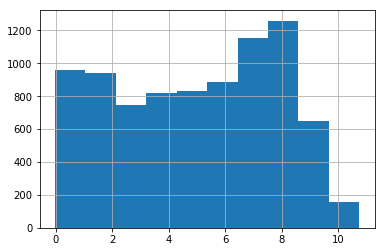

In [31]:
test['ans'].hist()

In [32]:
test['ans'].describe()

count    8409.000000
mean        4.988513
std         2.827069
min        -0.023130
25%         2.434297
50%         5.229197
75%         7.490034
max        10.749679
Name: ans, dtype: float64

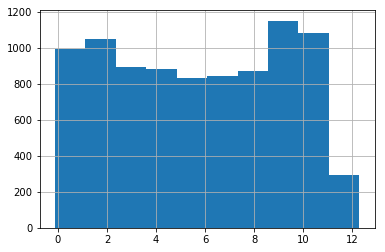

In [33]:
train['y'].hist()

In [34]:
train['y'].describe()

count    8896.000000
mean        5.746802
std         3.442017
min        -0.125144
25%         2.594826
50%         5.829831
75%         8.922216
max        12.288756
Name: y, dtype: float64